In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

# ----------------- Classics -------------------- #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Pandas settings --------------- #
# Removes rows and columns truncation of '...'
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ------------------- Python libs ---------------- #
import os, sys
from pathlib import Path
ROOT_PATH = Path().resolve().parent
sys.path.append(str(ROOT_PATH)) # Add folder root path

# ------------------- NLP libs ---------------------- #
from utils.tokenizer import Tokenizer
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA 

In [2]:
def load_queries(input_fpath: Path, dtype: str = 'csv', cols_to_keep=['topic-id', 'query', 'question'], index_col=['topic-id']) -> pd.DataFrame:
    """Loads queries file and returns it as pandas data frame
    """
    if dtype == 'csv':
        df = pd.read_csv(input_fpath, quotechar='"', index_col=index_col, usecols=cols_to_keep)
        # for each column
        for col in df.columns:
            # check if the columns contains string data
            if pd.api.types.is_string_dtype(df[col]):
                df[col] = df[col].str.strip() # removes front and end white spaces
                df[col] = df[col].str.replace('\s{2,}', ' ') # remove double or more white spaces
    return df

QUERY_FPATH = Path('../data/CORD-19/CORD-19/topics-rnd3.csv')
query_df = load_queries(QUERY_FPATH)
query_df.head()

,query,question
topic-id,,
1,coronavirus origin,what is the origin of COVID-19
2,coronavirus response to weather changes,how does the coronavirus respond to changes in...
3,coronavirus immunity,will SARS-CoV2 infected people develop immunit...
4,how do people die from the coronavirus,what causes death from Covid-19?
5,animal models of COVID-19,what drugs have been active against SARS-CoV o...


In [3]:
tk = Tokenizer('l-s-pt-lm')
docs = [tk.tokenize(doc) for doc in query_df['query'].values]
len(docs)

40

In [4]:
from collections import Counter

def count(docs):
    word_counts = Counter()
    appears_in = Counter()
    total_docs = len(docs)
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())
    wc = pd.DataFrame(temp, columns = ['word', 'count'])
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    return wc.sort_values(by='rank')

wc = count(docs)
wc

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
1,coronavirus,35,35,1.0,0.321101,0.321101,0.875
12,test,2,3,2.0,0.027523,0.348624,0.050
2,response,2,2,3.0,0.018349,0.366972,0.050
10,covid-19,2,2,4.0,0.018349,0.385321,0.050
17,impact,2,2,5.0,0.018349,0.403670,0.050
61,sars-cov-2,2,2,6.0,0.018349,0.422018,0.050
0,origin,1,1,7.0,0.009174,0.431193,0.025
4,weather,1,1,8.0,0.009174,0.440367,0.025
3,change,1,1,9.0,0.009174,0.449541,0.025
5,immunity,1,1,10.0,0.009174,0.458716,0.025


In [5]:
wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
1,coronavirus,35,35,1.0,0.321101,0.321101,0.875
12,test,2,3,2.0,0.027523,0.348624,0.050
2,response,2,2,3.0,0.018349,0.366972,0.050
10,covid-19,2,2,4.0,0.018349,0.385321,0.050
17,impact,2,2,5.0,0.018349,0.403670,0.050
61,sars-cov-2,2,2,6.0,0.018349,0.422018,0.050
0,origin,1,1,7.0,0.009174,0.431193,0.025
4,weather,1,1,8.0,0.009174,0.440367,0.025
3,change,1,1,9.0,0.009174,0.449541,0.025
5,immunity,1,1,10.0,0.009174,0.458716,0.025


In [6]:
cbow_vectors = KeyedVectors.load("../data/embeddings/cbow_word2vec.bin")

In [7]:
top10 = wc[wc['rank'] <= 10]
top10 = top10['word'].values
top10

array(['coronavirus', 'test', 'response', 'covid-19', 'impact',
       'sars-cov-2', 'origin', 'weather', 'change', 'immunity'],
      dtype=object)

In [8]:
for word in top10:
    print(f'--------- {word} ---------')
    results = cbow_vectors.wv.most_similar(positive=word, topn=10)
    for k, v in results:
        print(f"{k}, {v:.2f}")

--------- coronavirus ---------
corona, 0.83
coronavirus-2, 0.82
2019, 0.81
(sars)-cov-2, 0.81
syndrome-related, 0.80
disease-2019, 0.80
sars-cov-2, 0.80
-coronavirus, 0.79
sars-associated, 0.77
syndrome-coronavirus-2, 0.77
--------- test ---------
testing, 0.75
clia, 0.74
positive, 0.74
confirmatory, 0.73
igm/igg, 0.72
false-positive, 0.72
serology, 0.71
sample, 0.70
rrt-pcr, 0.70
dif, 0.69
--------- response ---------
immune, 0.85
humoral, 0.81
adaptive, 0.78
innate, 0.77
immunity, 0.77
cell-mediated, 0.74
th1, 0.73
pdcs, 0.73
elicit, 0.73
immunopathology, 0.72
--------- covid-19 ---------
2019, 0.87
covid, 0.86
covid19, 0.86
disease-19, 0.84
disease-2019, 0.83
wuhan, 0.81
declare, 0.79
-19, 0.78
epicenter, 0.78
covid-, 0.78
--------- impact ---------
socio-economic, 0.77
mitigate, 0.76
societal, 0.73
factors, 0.72
avoidable, 0.72
adrd, 0.71
economic, 0.71
population-level, 0.71
mitigation, 0.70
risks, 0.70
--------- sars-cov-2 ---------
sars-cov2, 0.85
2019-ncov, 0.81
cov-2, 0.81
co

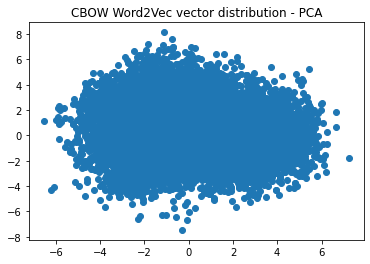

In [9]:
model = cbow_vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
fig, ax = plt.subplots()
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('CBOW Word2Vec vector distribution - PCA')
plt.show()

In [24]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, init='pca', random_state=42)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    plt.figure(figsize=(10, 6)) 
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()

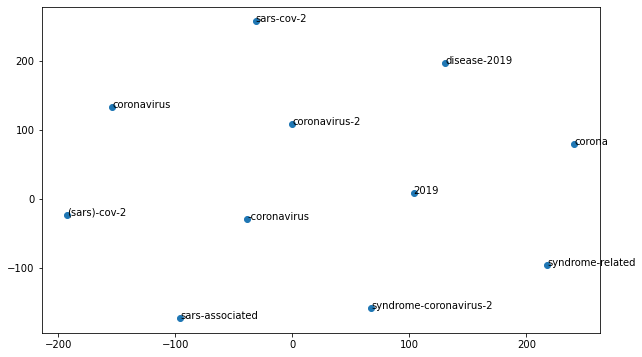

In [25]:
 display_closestwords_tsnescatterplot(cbow_vectors, 'coronavirus')

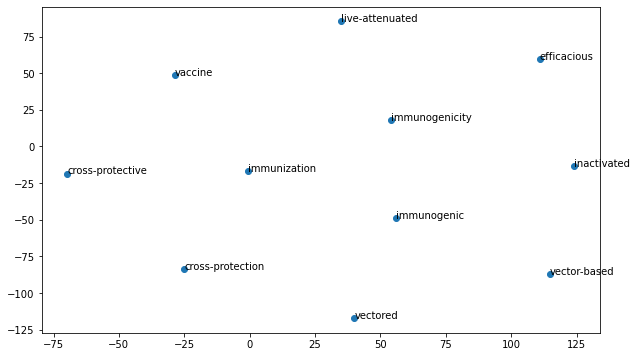

In [26]:
 display_closestwords_tsnescatterplot(cbow_vectors, 'vaccine')

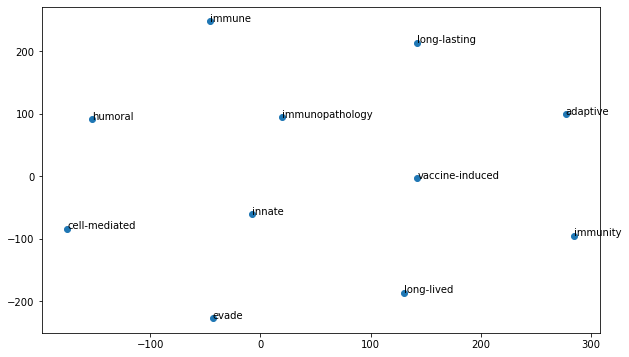

In [27]:
 display_closestwords_tsnescatterplot(cbow_vectors, 'immunity')